# 量子神经网络的贫瘠高原效应 （Barren Plateaus）

<em> Copyright (c) 2020 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>


## 概览

在经典神经网络的训练中，基于梯度的优化方法不仅仅会遇到局部最小值的问题，同时还要面对在鞍点附近梯度消失的问题。相对应的，在量子神经网络中也存在着一种**贫瘠高原效应**（Barren plateaus）。这个奇特的现象首先是由 McClean et al. 在 2018 年发现的 [1][[arXiv:1803.11173]](https://arxiv.org/abs/1803.11173)。简单来说，当你选取的随机电路结构满足一定复杂程度时，优化曲面（Optimization landscape）会变得很平坦, 从而导致基于梯度下降的优化方法很难找到全局最小值。对于大多数的变分量子算法（VQE等等），这个现象意味着当量子比特数量越来越多时，选取随机结构的电路有可能效果并不好。这会让你设计的损失函数所对应的优化曲面变成一个巨大的高原，从而导致量子神经网络的训练愈加困难。你随机找到的初始值很难逃离这个高原，梯度下降收敛速度会很缓慢。

<img src="figures/barren.png" width="680" >

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
图片由 [Gradient Descent Viz](https://github.com/lilipads/gradient_descent_viz) 生成

本教程主要讨论如何在量桨（PaddleQuantum）平台上展示贫瘠高原这一现象。其中并不涉及任何算法创新，但能提升读者对于量子神经网络训练中梯度问题的认识。首先我们先引入必要的 library和 package：

In [1]:
import time
import numpy as np

from progressbar import ProgressBar
from matplotlib import pyplot as plt 
from scipy.stats import unitary_group    

import paddle.fluid as fluid
from paddle.fluid.framework import ComplexVariable
from paddle.complex import matmul, transpose   
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import dagger
from paddle_quantum.state import density_op

## 随机的网络结构

这里我们按照原作者 McClean (2018)论文中提及的类似方法搭建如下随机电路（目前我们不支持内置的 control-Z 门，方便起见用 CNOT 替代）：

<img src="figures/Barren_circuit.png" width="400" >
首先作用在所有量子比特上绕布洛赫球的 Y-轴旋转 $\pi/4$。

以上结构加起来构成一个模块（Block）, 每个模块共分为两层：

- 第一层搭建随机的旋转门, 其中 $R_{\ell,n} \in \{R_x, R_y, R_z\}$。下标 $\ell$ 表示处于第 $\ell$ 个重复的模块， 上图中 $\ell =1$。第二个下标 $n$ 表示作用在第几个量子比特上。
- 第二层由 CNOT 门组成，作用在每两个相邻的量子比特上。

在量桨中, 我们可以这么搭建。


In [2]:
def rand_circuit(theta, target, num_qubits):
    
    # 我们需要将 Numpy array 转换成 Paddle 动态图模式中支持的 variable
    const = fluid.dygraph.to_variable(np.array([np.pi/4]))
    
    # 初始化量子电路
    cir = UAnsatz(num_qubits)
    
    # ============== 第一层 ==============
    # 固定角度的 Ry 旋转门
    for i in range(num_qubits):
        cir.ry(const, i)

    # ============== 第二层 ==============
    # target是一个随机的数组,用来帮助我们抽取随机的单比特门 
    for i in range(num_qubits):
        if target[i] == 0:
            cir.rz(theta[i], i)
        elif target[i] == 1:
            cir.ry(theta[i], i)
        else:
            cir.rx(theta[i], i)
            

    # ============== 第三层 ==============
    # 搭建两两相邻的 CNOT 门
    for i in range(num_qubits - 1):
        cir.cnot([i, i + 1])
        
    return cir.U

## 损失函数与优化曲面 

当我们确定了电路的结构之后，我们还需要定义一个损失函数（Loss function）来确定优化曲面（Optimization landscape）。按照原作者 McClean (2018)论文中提及的，我们采用 VQE算法中常用的损失函数：
$$
\mathcal{L}= \langle{0} \lvert U^{\dagger}(\boldsymbol{\theta})H U(\boldsymbol{\theta}) \lvert {0}\rangle
$$

其中的酉矩阵 $U(\boldsymbol{\theta})$ 就是我们上一部分搭建的带有随机结构的量子神经网络。对于其中的哈密顿量 $H$ 我们不妨先取最简单的形式 $H = \lvert {00\cdots 0}\rangle\langle{00\cdots 0} \lvert$。设定好这些后，我们就可以从最简单的两个量子比特的情形开始采样了 -- 生成 300 组随机网络结构和不同的随机初始参数 $\{\theta_{\ell,n}^{(i)}\}_{i=1}^{300}$。每次计算梯度都是按照 VQE 的解析梯度公式计算关于**第一个参数 $\theta_{1,1}$**的偏导数。然后统计得到的这 300 个梯度的平均值和方差。其中解析梯度的公式为：

$$
\partial \theta_{j} 
\equiv \frac{\partial \mathcal{L}}{\partial \theta_j}
= \frac{1}{2} \big[\mathcal{L}(\theta_j + \frac{\pi}{2}) - \mathcal{L}(\theta_j - \frac{\pi}{2})\big]
$$

具体推导请参见：[arXiv:1803.00745](https://arxiv.org/abs/1803.00745)

In [3]:
# 超参数设置
np.random.seed(42)        # 固定 Numpy 的随机种子
N = 2                     # 设置量子比特数量 
samples = 300             # 设定采样随机网络结构的数量
THETA_SIZE = N            # 设置参数 theta 的大小
ITR = 1                   # 设置迭代次数
LR = 0.2                  # 设定学习速率
SEED = 1                  # 固定优化器中随机初始化的种子

# 初始化梯度数值的寄存器
grad_info = []

class manual_gradient(fluid.dygraph.Layer):
    
    # 初始化一个长度为 THETA_SIZE 的可学习参数列表，并用 [0, 2*pi] 的均匀分布来填充初始值
    def __init__(self, shape, param_attr=fluid.initializer.Uniform(
        low=0.0, high=2 * np.pi, seed=1),dtype='float64'):
        super(manual_gradient, self).__init__()
        
        # 我们需要将 Numpy array 转换成 Paddle 动态图模式中支持的 variable
        self.H = fluid.dygraph.to_variable(density_op(N))
        
    # 定义损失函数和前向传播机制    
    def forward(self):
        
        # 初始化三个 theta 参数列表
        theta_np = np.random.uniform(
            low=0., high= 2 * np.pi, size=(THETA_SIZE))
        theta_plus_np = np.copy(theta_np) 
        theta_minus_np = np.copy(theta_np) 
        
        # 修改用以计算解析梯度
        theta_plus_np[0] += np.pi/2
        theta_minus_np[0] -= np.pi/2
        
        # 我们需要将 Numpy array 转换成 Paddle 动态图模式中支持的 variable
        theta = fluid.dygraph.to_variable(theta_np)
        theta_plus = fluid.dygraph.to_variable(theta_plus_np)
        theta_minus = fluid.dygraph.to_variable(theta_minus_np)
        
        # 生成随机目标，在 rand_circuit 中随机选取电路门
        target = np.random.choice(3, N)      
        
        U = rand_circuit(theta, target, N)
        U_dagger = dagger(U) 
        U_plus = rand_circuit(theta_plus, target, N)
        U_plus_dagger = dagger(U_plus) 
        U_minus = rand_circuit(theta_minus, target, N)
        U_minus_dagger = dagger(U_minus) 

        # 计算解析梯度
        grad = ( matmul(matmul(U_plus_dagger, self.H), U_plus).real[0][0]  
                - matmul(matmul(U_minus_dagger, self.H), U_minus).real[0][0])/2  
        return grad

# 定义主程序段
def main():
    
    # 初始化paddle动态图机制
    with fluid.dygraph.guard():
        
        sampling = manual_gradient(shape=[THETA_SIZE])
        
        # 采样获得梯度信息
        grad = sampling()   
        
    return grad.numpy()


# 记录运行时间
time_start = time.time()

# 开始采样
for i in range(samples):
    if __name__ == '__main__':
        grad = main()
        grad_info.append(grad)

time_span = time.time() - time_start        
print('主程序段总共运行了', time_span, '秒')
print("采样", samples, "个随机网络关于第一个参数梯度的均值是：", np.mean(grad_info))
print("采样", samples, "个随机网络关于第一个参数梯度的方差是：", np.var(grad_info))

主程序段总共运行了 12.4281587600708 秒
采样 300 个随机网络关于第一个参数梯度的均值是： 0.005925709445960605
采样 300 个随机网络关于第一个参数梯度的方差是： 0.028249053148446363


## 优化曲面的可视化

接下来我们试着利用 Matplotlib来可视化这个优化曲面（Optimization landscape）。在**两个量子比特**的情况下，我们只有两个参数 $\theta_1$ 和 $\theta_2$, 并且第二层的随机电路电路总共有9种情况。这个很容易画出来：

<img src="figures/landscape2.png" width="1000" >

可以看到的是最后一张图中 $R_z$-$R_z$ 结构所展示出的高原结构是我们非常不想见到的。在这种情况下，我们不能收敛到理论最小值。如果你想自己试着画一些优化曲面，不妨参见以下代码：

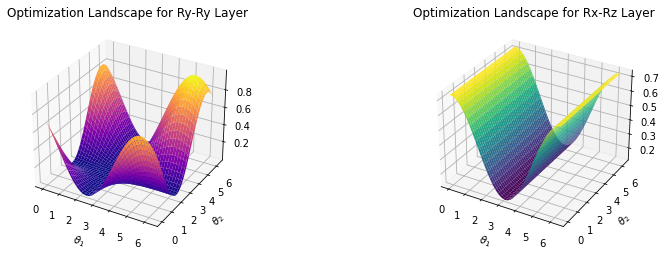

主程序段总共运行了 4.053140163421631 秒


In [4]:
# 引入必要的 package
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

time_start = time.time()
N = 2

# 设置图像比例 竖：横 = 0.3 
fig = plt.figure(figsize=plt.figaspect(0.3))

# 生成 x, y 轴上的点
X = np.linspace(0, 2*np.pi, 80)
Y = np.linspace(0, 2*np.pi, 80)

# 生成 2D 网格 (mesh)
xx, yy = np.meshgrid(X, Y)


# 定义必要的逻辑门
def rx(theta):
    mat = np.array([[np.cos(theta/2), -1j*np.sin(theta/2)],
                    [-1j*np.sin(theta/2), np.cos(theta/2)]])
    return mat

def ry(theta):
    mat = np.array([[np.cos(theta/2), -1*np.sin(theta/2)],
                    [np.sin(theta/2), np.cos(theta/2)]])
    return mat

def rz(theta):
    mat = np.array([[np.exp(-1j*theta/2), 0],
                    [0, np.exp(1j*theta/2)]])
    return mat

def CNOT():
    mat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
    return mat

# ============= 第一张图 =============
# 我们可视化第二层是 kron(Ry, Ry) 的情况
ax = fig.add_subplot(1, 2, 1, projection='3d')

# 向前传播计算损失函数：
def cost_yy(para):
    L1 = np.kron(ry(np.pi/4), ry(np.pi/4))
    L2 = np.kron(ry(para[0]), ry(para[1]))
    U = np.matmul(np.matmul(L1, L2), CNOT())
    H = np.zeros((2 ** N, 2 ** N))
    H[0, 0] = 1
    val = (U.conj().T @ H@ U).real[0][0]
    return val

# 画出图像
Z = np.array([[cost_yy([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap='plasma')
#cset = ax.contourf(xx, yy, Z, zdir='z', offset=np.min(Z), cmap='viridis')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Ry-Ry Layer")
#fig.colorbar(surf, shrink=0.5, aspect=5)

# ============= 第二张图 =============
# 我们可视化第二层是 kron(Rx, Rz) 的情况
ax = fig.add_subplot(1, 2, 2, projection='3d')

def cost_xz(para):
    L1 = np.kron(ry(np.pi/4), ry(np.pi/4))
    L2 = np.kron(rx(para[0]), rz(para[1]))
    U = np.matmul(np.matmul(L1, L2), CNOT())
    H = np.zeros((2 ** N, 2 ** N))
    H[0, 0] = 1
    val = (U.conj().T @ H@ U).real[0][0]
    return val

Z = np.array([[cost_xz([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap='viridis')
#cset = ax.contourf(xx, yy, Z, zdir='z', offset=np.min(Z), cmap='viridis')
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\theta_2$")
ax.set_title("Optimization Landscape for Rx-Rz Layer")


plt.show()

time_span = time.time() - time_start        
print('主程序段总共运行了', time_span, '秒')

## 更多的量子比特

接着我们再看看不断的增加量子比特的数量，会对我们的梯度带来什么影响。

In [5]:
# 超参数设置
selected_qubit = [2, 4, 6, 8]
samples = 300
grad_val = []
means, variances = [], []

# 记录运算时长
time_start = time.time()

# 不断增加量子比特数量
for N in selected_qubit:
    grad_info = []
    THETA_SIZE = N
    pbar = ProgressBar()
    for i in pbar(range(samples)):
        class manual_gradient(fluid.dygraph.Layer):
            # 初始化一个长度为 THETA_SIZE 的可学习参数列表
            def __init__(self, shape, param_attr=fluid.initializer.Uniform(
                low=0.0, high=2 * np.pi, seed=1),dtype='float64'):
                super(manual_gradient, self).__init__()

                # 我们需要将 Numpy array 转换成 Paddle 动态图模式中支持的 variable
                self.H = fluid.dygraph.to_variable(
                         density_op(N))

            # 定义损失函数和前向传播机制    
            def forward(self):

                # 初始化三个 theta 参数列表
                theta_np = np.random.uniform(
                    low=0., high= 2 * np.pi, size=(THETA_SIZE))
                theta_plus_np = np.copy(theta_np) 
                theta_minus_np = np.copy(theta_np) 

                # 修改用以计算解析梯度
                theta_plus_np[0] += np.pi/2
                theta_minus_np[0] -= np.pi/2

                # 我们需要将 Numpy array 转换成 Paddle 动态图模式中支持的 variable
                theta = fluid.dygraph.to_variable(theta_np)
                theta_plus = fluid.dygraph.to_variable(theta_plus_np)
                theta_minus = fluid.dygraph.to_variable(theta_minus_np)

                # 生成随机目标，在 rand_circuit 中随机选取电路门
                target = np.random.choice(3, N)      
                
                U = rand_circuit(theta, target, N)
                U_dagger = dagger(U) 

                U_plus = rand_circuit(theta_plus, target, N)
                U_plus_dagger = dagger(U_plus) 

                U_minus = rand_circuit(theta_minus, target, N)
                U_minus_dagger = dagger(U_minus) 

                # 计算解析梯度
                grad = ( matmul(matmul(U_plus_dagger, self.H), 
                                U_plus).real[0][0]  
                        - matmul(matmul(U_minus_dagger, self.H), 
                                 U_minus).real[0][0])/2  
                return grad      
            
           
        # 定义主程序段    
        def main():
            # 初始化paddle动态图机制
            with fluid.dygraph.guard():

                sampling = manual_gradient(shape=[THETA_SIZE])
                
                # 采样获得梯度信息
                grad = sampling()
                
            return grad.numpy()
        
        if __name__ == '__main__':
            grad = main()
            grad_info.append(grad)
            
    # 记录采样信息
    grad_val.append(grad_info) 
    means.append(np.mean(grad_info))
    variances.append(np.var(grad_info))
    
time_span = time.time() - time_start        
print('主程序段总共运行了', time_span, '秒')

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


主程序段总共运行了 424.13999366760254 秒


我们接着画出这个采样出来的梯度的统计结果：


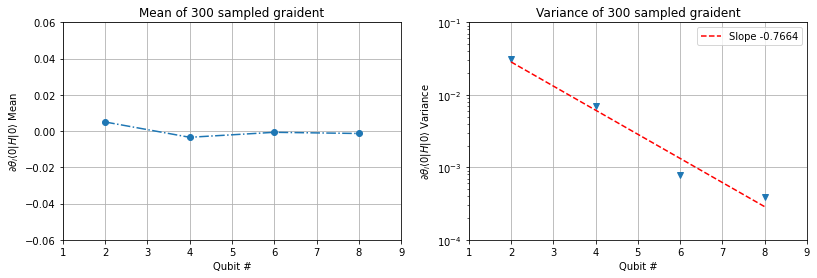

In [6]:
grad = np.array(grad_val)
means = np.array(means)
variances = np.array(variances)
n = np.array(selected_qubit)
print("我们接着画出这个采样出来的梯度的统计结果：")
fig = plt.figure(figsize=plt.figaspect(0.3))


# ============= 第一张图 =============
# 统计出随机采样的梯度平均值和量子比特数量的关系
plt.subplot(1, 2, 1)
plt.plot(n, means, "o-.")
plt.xlabel(r"Qubit #")
plt.ylabel(r"$ \partial \theta_{i} \langle 0|H |0\rangle$ Mean")
plt.title("Mean of {} sampled graident".format(samples))
plt.xlim([1,9])
plt.ylim([-0.06, 0.06])
plt.grid()

# ============= 第二张图 =============
# 统计出随机采样的梯度的方差和量子比特数量的关系
plt.subplot(1, 2, 2)
plt.semilogy(n, variances, "v")

# 多项式拟合
fit = np.polyfit(n, np.log(variances), 1)
slope = fit[0] 
intercept = fit[1] 
plt.semilogy(n, np.exp(n*slope  + intercept), "r--", label="Slope {:03.4f}".format(slope))
plt.xlabel(r"Qubit #")
plt.ylabel(r"$ \partial \theta_{i} \langle 0|H |0\rangle$ Variance")
plt.title("Variance of {} sampled graident".format(samples))
plt.legend()
plt.xlim([1,9])
plt.ylim([0.0001, 0.1])
plt.grid()

plt.show()

要注意的是，在理论上，只有当我们选取的网络结构还有损失函数满足一定条件时 (2-design)详见论文 [[1]](https://arxiv.org/abs/1803.11173), 才会出现这种效应。接着我们不妨可视化一下不同量子比特数量对的优化曲面的影响：

<img src="figures/qubit_landscape_compare.png" width="1000" >

**图 1.** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
(a). 2-量子比特 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
(b). 4-量子比特 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
(c). 6-量子比特

画图时 $\theta_1$ 和 $\theta_2$ 是前两个电路参数, 剩余参数全部固定为 $\pi$。不然我们画不出这个高维度的流形。
结果不出所料，陡峭程度随着 $n$ 的增大越来越小了，**注意到 Z 轴尺度的极速减小**。相对于2量子比特的情况，6量子比特的优化曲面已经非常扁平了。

<hr/>

## 参考文献

[1] [McClean, J. R., Boixo, S., Smelyanskiy, V. N., Babbush, R. & Neven, H. Barren plateaus in quantum neural network training landscapes. Nat. Commun. 9, 4812 (2018).](https://www.nature.com/articles/s41467-018-07090-4)


[2] [Cerezo, M., Sone, A., Volkoff, T., Cincio, L. & Coles, P. J. Cost-Function-Dependent Barren Plateaus in Shallow Quantum Neural Networks. arXiv:2001.00550 (2020).](https://arxiv.org/abs/2001.00550)